<a href="https://colab.research.google.com/github/TheMadMax-8/IPL-Win-Predictor-App/blob/main/IPL_Win_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import pandas as pd

In [36]:
match = pd.read_csv('/content/matches.csv')
delivery = pd.read_csv('/content/deliveries.csv')

In [37]:
print(match.head(2))
print(delivery.head(2))

   id    Season       city        date                team1  \
0   1  IPL-2017  Hyderabad  05-04-2017  Sunrisers Hyderabad   
1   2  IPL-2017       Pune  06-04-2017       Mumbai Indians   

                         team2                  toss_winner toss_decision  \
0  Royal Challengers Bangalore  Royal Challengers Bangalore         field   
1       Rising Pune Supergiant       Rising Pune Supergiant         field   

   result  dl_applied                  winner  win_by_runs  win_by_wickets  \
0  normal           0     Sunrisers Hyderabad           35               0   
1  normal           0  Rising Pune Supergiant            0               7   

  player_of_match                                      venue         umpire1  \
0    Yuvraj Singh  Rajiv Gandhi International Stadium, Uppal     AY Dandekar   
1       SPD Smith    Maharashtra Cricket Association Stadium  A Nand Kishore   

    umpire2 umpire3  
0  NJ Llong     NaN  
1    S Ravi     NaN  
   match_id  inning         batting_

In [38]:
total_score = delivery.groupby(['match_id', 'inning']).sum()['total_runs'].reset_index()
total_score = total_score[total_score['inning'] == 1]

print(total_score.head(3))

   match_id  inning  total_runs
0         1       1         207
2         2       1         184
4         3       1         183


In [39]:
match_df = match.merge(total_score[['match_id', 'total_runs']],left_on = 'id', right_on = 'match_id')

# print(match_df.head(5))
print(match_df['team1'].unique())

['Sunrisers Hyderabad' 'Mumbai Indians' 'Gujarat Lions'
 'Rising Pune Supergiant' 'Royal Challengers Bangalore'
 'Kolkata Knight Riders' 'Delhi Daredevils' 'Kings XI Punjab'
 'Chennai Super Kings' 'Rajasthan Royals' 'Deccan Chargers'
 'Kochi Tuskers Kerala' 'Pune Warriors' 'Rising Pune Supergiants'
 'Delhi Capitals']


In [40]:
# Update Names.
# Remove Teams Which Are Not Part Of Current IPL (Data Is Till 2018).

teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]

match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils', 'Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils', 'Delhi Capitals')

match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')

match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

In [41]:
# Exclude Matches Affected With Rain.
# These Are Marked With DLS Applied Or Not.

match_df = match_df[match_df['dl_applied'] == 0]

In [42]:
# Extract Features From The Match Table And Merge With Delivery Table.
# The Missing Attributes In Delivery Table Are City, Winner And Total Runs.

match_df = match_df[['match_id', 'city', 'winner', 'total_runs']]

delivery_df = match_df.merge(delivery, on = 'match_id')
delivery_df = delivery_df[delivery_df['inning'] == 2]

# print(delivery_df.head(2))

In [43]:
# Ensure Values To Be Numeric Values.
# Handle Errors By Considering Them As NaN.

delivery_df['total_runs_y'] = pd.to_numeric(delivery_df['total_runs_y'], errors = 'coerce')

delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()
delivery_df['runs_left'] = delivery_df['total_runs_x'] + 1 - delivery_df['current_score'] # Target Is Score In 1st Innings + 1.

delivery_df['balls_left'] = 120 - (delivery_df['over'] * 6 + delivery_df['ball'] - 6)

# print(delivery_df.head(2))

In [44]:
valid_dismissals = [
    'bowled', 'caught', 'lbw', 'stumped', 'caught and bowled', 'hit wicket',
    'obstructing the field', 'hit the ball twice', 'run out'
]

delivery_df['dismissal_flag'] = delivery_df['dismissal_kind'].apply(lambda x: 1 if x in valid_dismissals else 0)
delivery_df['wickets_fallen'] = delivery_df.groupby('match_id')['dismissal_flag'].cumsum()

delivery_df['wickets_left'] = 10 - delivery_df['wickets_fallen']
delivery_df.head(3)

delivery_df.tail(3)

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,total_runs_y,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,dismissal_flag,wickets_fallen,wickets_left
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,1,SR Watson,run out,KH Pandya,155,-2,2,1,6,4
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,2,NaN,NaN,NaN,157,-4,1,0,6,4
149577,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,6,SN Thakur,...,0,SN Thakur,lbw,NaN,157,-4,0,1,7,3


In [45]:
delivery_df['crr'] = (delivery_df['current_score'] * 6) / (120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / delivery_df['balls_left']

print(delivery_df.head(2))

     match_id       city               winner  total_runs_x  inning  \
125         1  Hyderabad  Sunrisers Hyderabad           207       2   
126         1  Hyderabad  Sunrisers Hyderabad           207       2   

                    batting_team         bowling_team  over  ball  \
125  Royal Challengers Bangalore  Sunrisers Hyderabad     1     1   
126  Royal Challengers Bangalore  Sunrisers Hyderabad     1     2   

           batsman  ... dismissal_kind fielder  current_score  runs_left  \
125       CH Gayle  ...            NaN     NaN              1        207   
126  Mandeep Singh  ...            NaN     NaN              1        207   

     balls_left  dismissal_flag  wickets_fallen  wickets_left  crr        rrr  
125         119               0               0            10  6.0  10.436975  
126         118               0               0            10  3.0  10.525424  

[2 rows x 32 columns]


In [46]:
# Evaluate Whether The Batting Team Emerged As Winner Or Not.

def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

delivery_df['result'] = delivery_df.apply(result, axis = 1)
# delivery_df.head(2)

In [47]:
# Refine The Actual Columns We Need For Our Prediction.

final_df = delivery_df[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'total_runs_x', 'crr', 'rrr', 'result']]
# print(final_df.head(2))

# Randomly Shuffle The Balls.

final_df = final_df.sample(final_df.shape[0])
# final_df.head(2)

In [48]:
final_df.dropna(inplace = True)
final_df = final_df[final_df['balls_left'] != 0]

In [15]:
x = final_df.iloc[:, :-1]
y = final_df.iloc[:, -1]

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.4, random_state = 42)

print(X_train)

                       batting_team                 bowling_team       city  \
22287                Mumbai Indians              Deccan Chargers     Durban   
83343         Kolkata Knight Riders  Royal Challengers Bangalore     Ranchi   
32817               Deccan Chargers             Delhi Daredevils  Centurion   
146307  Royal Challengers Bangalore               Delhi Capitals      Delhi   
116636          Sunrisers Hyderabad              Kings XI Punjab  Hyderabad   
...                             ...                          ...        ...   
129648        Kolkata Knight Riders               Mumbai Indians     Mumbai   
142214          Chennai Super Kings        Kolkata Knight Riders    Kolkata   
78939   Royal Challengers Bangalore               Mumbai Indians     Mumbai   
128005        Kolkata Knight Riders  Royal Challengers Bangalore  Bengaluru   
78241           Chennai Super Kings          Sunrisers Hyderabad    Chennai   

        runs_left  balls_left  wickets_left  total_

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

transform = ColumnTransformer([('transform', OneHotEncoder(drop = 'first'), ['batting_team','bowling_team','city'])], remainder = 'passthrough')

In [17]:
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

from sklearn.pipeline import Pipeline

In [28]:
pipe = Pipeline(steps = [('step1', transform), ('step2', LogisticRegression(solver = 'liblinear', max_iter = 1000))])
pipe.fit(X_train, Y_train)

# pipe_RF = Pipeline(steps = [('transform', transform), ('clf', RandomForestClassifier(n_estimators = 100, random_state = 42))])
# pipe_RF.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transform',
                                                  OneHotEncoder(drop='first'),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2',
                 LogisticRegression(max_iter=1000, solver='liblinear'))])


Model Evaluation On Test Dataset
Logistic Regression: Accuracy = 0.7996, F1-score = 0.8117, ROC-AUC = 0.8867
Random Forest: Accuracy = 0.9975, F1-score = 0.9976, ROC-AUC = 0.9999


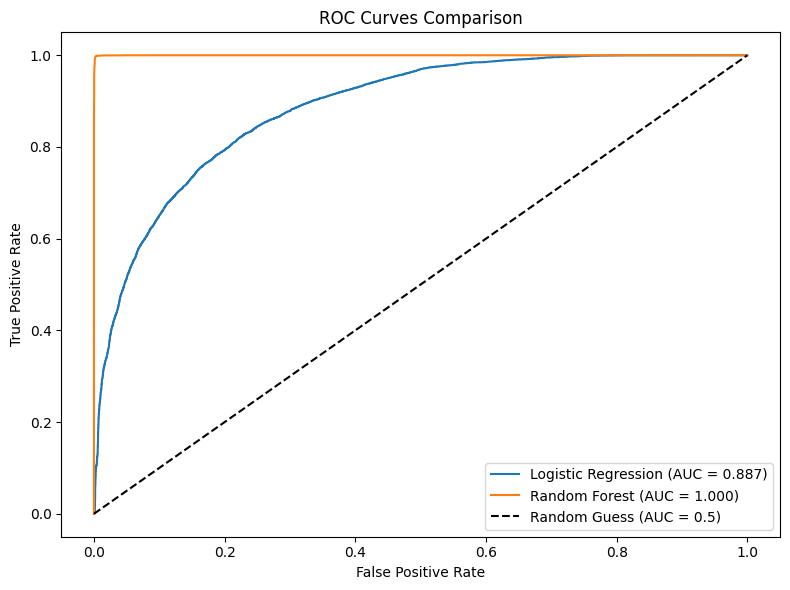

In [29]:
# Compare The Two Models.

models = [('Logistic Regression', pipe), ('Random Forest', pipe_RF)]
print("\nModel Evaluation On Test Dataset")

for name, pipe in models:

    Y_predict = pipe.predict(X_test)
    Y_probability = pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(Y_test, Y_predict)
    f1 = f1_score(Y_test, Y_predict)
    roc_auc = roc_auc_score(Y_test, Y_probability)

    print(f"{name}: Accuracy = {acc :.4f}, F1-score = {f1:.4f}, ROC-AUC = {roc_auc:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))

for name, pipe in models:

    Y_probability = pipe.predict_proba(X_test)[:, 1]

    false_positive_rate, true_positive_rate, _ = roc_curve(Y_test, Y_probability)
    roc_auc = roc_auc_score(Y_test, Y_probability)
    plt.plot(false_positive_rate, true_positive_rate, label = f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label = 'Random Guess (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC Curves Comparison')
plt.legend(loc = 'lower right')

plt.tight_layout()
plt.show()

Random Forest Leads To Overfitting On Training Dataset.
So; I Will Prefer Logistic Regression Here.

In [20]:
# from sklearn.metrics import accuracy_score

# Y_predict = pipe.predict(X_test)
# accuracy_score(Y_test, Y_predict)


In [30]:
# Predict Team Wise Probability Of Match ID 8.

pipe.predict_proba(X_test)[8]

array([0.89, 0.11])

In [31]:
# Functions To Generate Match Summary & Match Progression.

def match_summary(row):
    print("Batting Team - " + row['batting_team'] + " | Bowling Team - " + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))


def match_progression(x_df, match_id, pipe):

    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]

    temp_df = match[['batting_team', 'bowling_team', 'city', 'runs_left', 'balls_left', 'wickets_left', 'total_runs_x', 'crr', 'rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]

    result = pipe.predict_proba(temp_df)

    temp_df['lose'] = np.round(result.T[0] * 100, 1)
    temp_df['win'] = np.round(result.T[1] * 100, 1)

    temp_df['end_of_over'] = range(1, temp_df.shape[0] + 1)

    target = temp_df['total_runs_x'].values[0]
    runs = list(temp_df['runs_left'].values)

    new_runs = runs[:]
    runs.insert(0, target)

    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets_left'].values)

    new_wickets = wickets[:]
    new_wickets.insert(0, 10)

    wickets.append(0)

    w = np.array(wickets)
    nw = np.array(new_wickets)

    temp_df['wickets_in_over'] = (nw - w)[0 : temp_df.shape[0]]

    print("Target - ", target)

    temp_df = temp_df[['end_of_over', 'runs_after_over', 'wickets_in_over', 'lose', 'win']]
    return temp_df, target


In [32]:
temp_df, target = match_progression(delivery_df, 8, pipe)
print(temp_df.head(6))

Target -  148
     end_of_over  runs_after_over  wickets_in_over  lose    win
878            1                5                0  10.0   90.0
884            2                8                0   2.0   98.0
890            3               11                0   0.0  100.0
897            4               18                0   0.0  100.0
903            5                7                0   0.0  100.0
909            6               12                1   0.0  100.0


Text(0.5, 1.0, 'Target - 148')

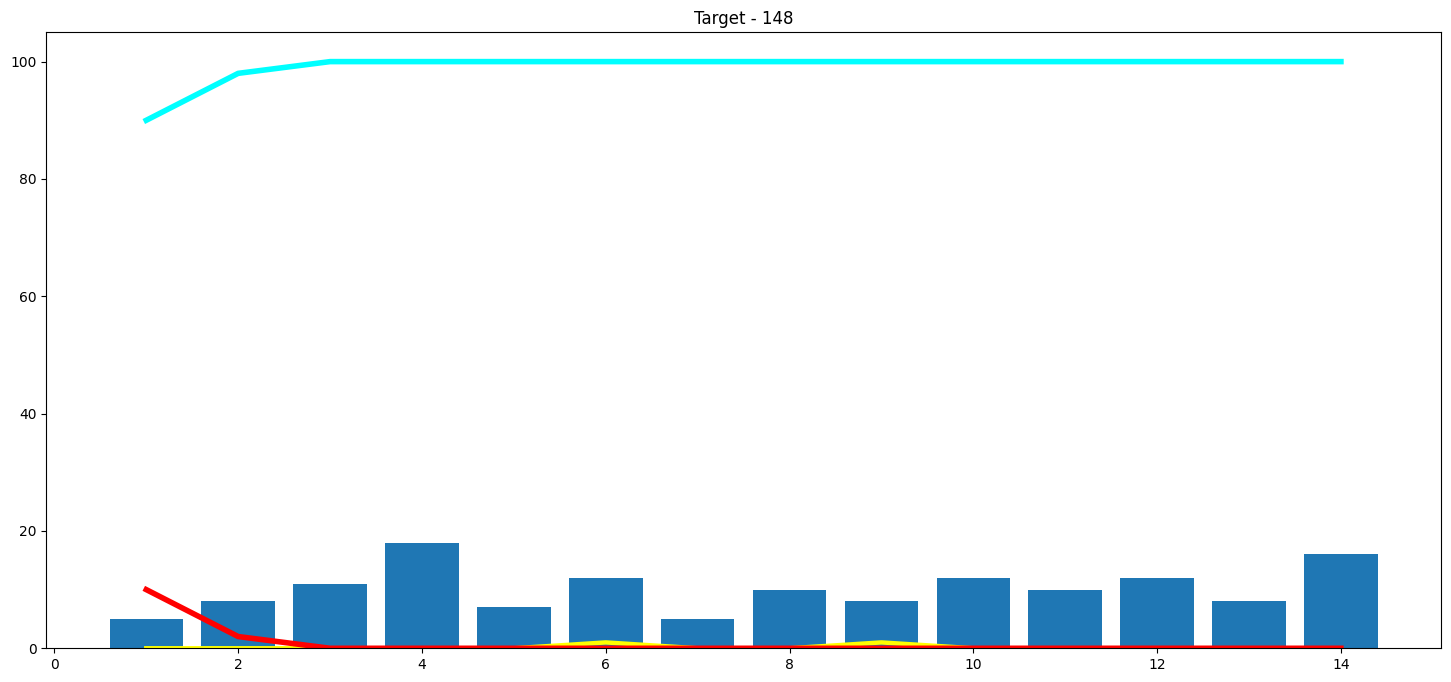

In [33]:
# Plot The Progression Of The Match With Live Win Probability.

import matplotlib.pyplot as plt

plt.figure(figsize = (18, 8))
plt.plot(temp_df['end_of_over'], temp_df['wickets_in_over'], color = 'yellow', linewidth = 3.2)
plt.plot(temp_df['end_of_over'], temp_df['win'], color = 'cyan', linewidth = 4)
plt.plot(temp_df['end_of_over'], temp_df['lose'], color = 'red', linewidth = 4)

plt.bar(temp_df['end_of_over'], temp_df['runs_after_over'])
plt.title('Target - ' + str(target))

In [34]:
# One Of The Nail Biters.

temp_df, target = match_progression(delivery_df, 74, pipe)
# print(temp_df.head(6))

Target -  178


Text(0.5, 1.0, 'Target - 178')

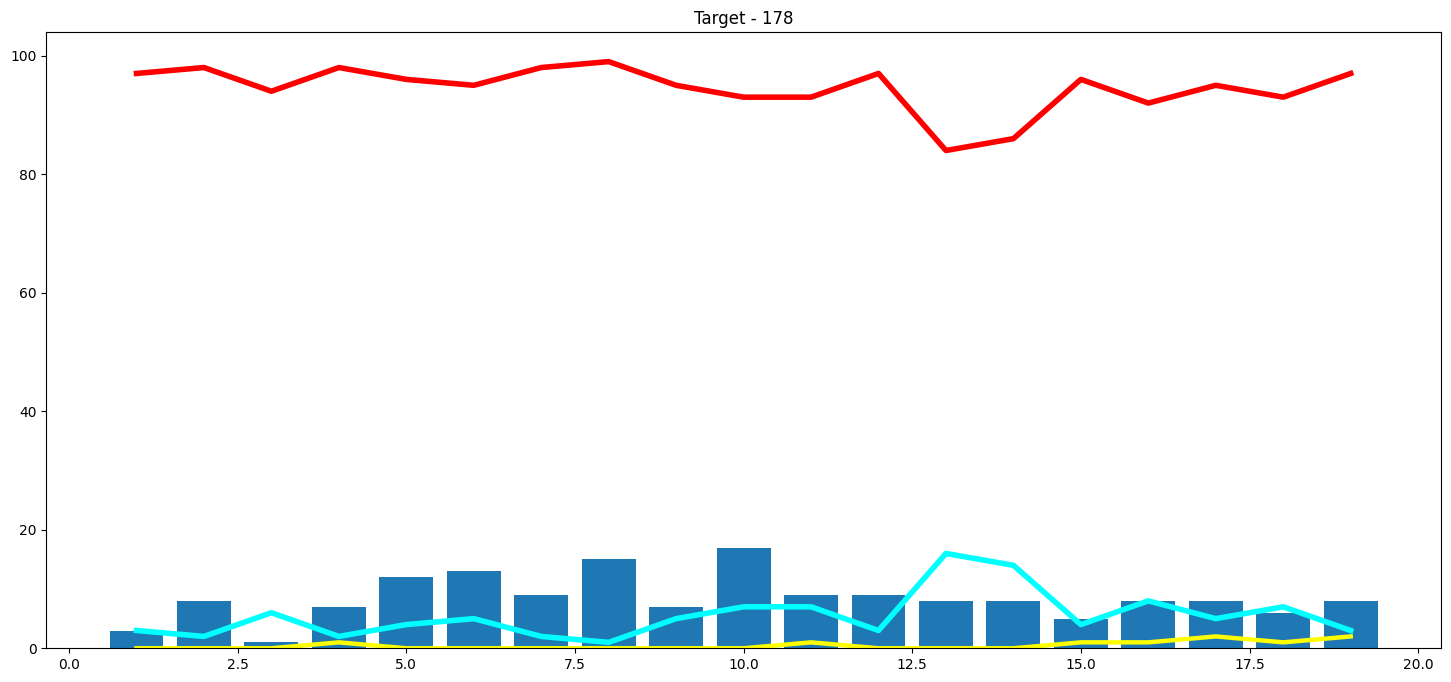

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize = (18, 8))
plt.plot(temp_df['end_of_over'], temp_df['wickets_in_over'], color = 'yellow', linewidth = 3.2)
plt.plot(temp_df['end_of_over'], temp_df['win'], color = 'cyan', linewidth = 4)
plt.plot(temp_df['end_of_over'], temp_df['lose'], color = 'red', linewidth = 4)

plt.bar(temp_df['end_of_over'], temp_df['runs_after_over'])
plt.title('Target - ' + str(target))

In [ ]:
# import joblib

# model_filename = 'win_prob_pipeline.joblib'
# joblib.dump(pipe, model_filename)

# print(f"Saved Pipeline To {model_filename}")


Saved Pipeline To win_prob_pipeline.joblib


In [ ]:
# from google.colab import files
# files.download('win_prob_pipeline.joblib')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import pickle
pickle.dump(pipe, open('pipe.pkl', 'wb'))

from google.colab import files
files.download('pipe.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>